## Import torch



In [ ]:
import torch
from torch import nn

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Get Data

In [ ]:
import requests
import zipfile
from pathlib import Path

#Setup path to a data folder
data_path = Path("data/")
Image_path = data_path / "pizza_steak_sushi"

#If the image folder doesn't exist, download it and prepare it...
if Image_path.is_dir():
    print(f"{Image_path} directory exists.")
else:
    print(f"Did not find {Image_path} directory, creating one...")
    Image_path.mkdir(parents=True, exist_ok=True)

with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza, steak, sushi data...")
    f.write(request.content)

#Unzip pizza, steak, sushi
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi data...")
    zip_ref.extractall(Image_path)

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


In [ ]:
import os
def walk_through_dir(dir_path):
  """Walks thorugh dir path returning its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [ ]:
walk_through_dir(Image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.


In [ ]:
#setup train and testing paths
train_dir = Image_path / "train"
test_dir = Image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

Random image path: data/pizza_steak_sushi/test/pizza/2019408.jpg
Class: pizza
Image size: (512, 512)


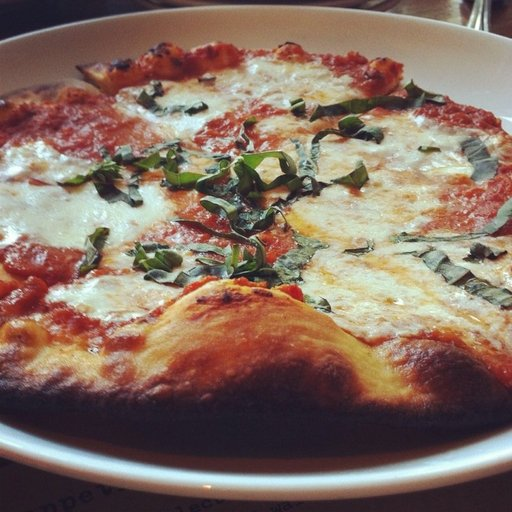

In [ ]:
import random
from PIL import Image

#set seed
random.seed(42)
#get all image paths
img_path_list = list(Image_path.glob("*/*/*.jpg"))
#pick a random image path
random_img_path = random.choice(img_path_list)
#get class name from image path
image_class = random_img_path.parent.stem
#open image
img = Image.open(random_img_path)
#print metadata
print(f"Random image path: {random_img_path}")
print(f"Class: {image_class}")
print(f"Image size: {img.size}")
img

(-0.5, 511.5, 511.5, -0.5)

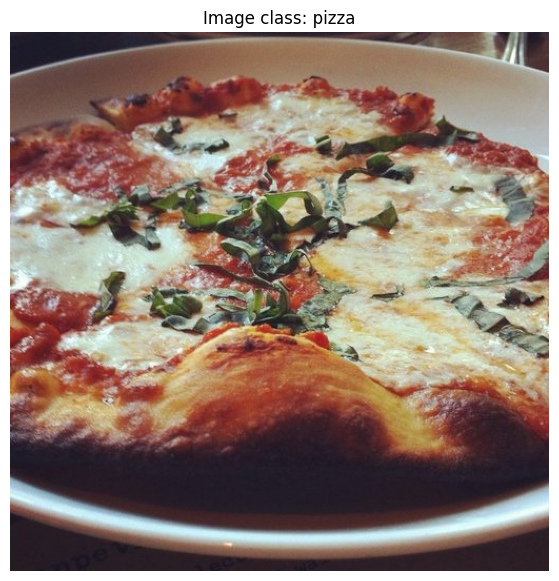

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#turn image into array
img_as_array = np.asarray(img)
#plot image
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class}")
plt.axis(False)

## Transforming Data

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [ ]:
#write a transform for image
data_transform = transforms.Compose([
    transforms.Resize((64,64)),
    #flip the image
    transforms.RandomHorizontalFlip(p=0.5),
    #turn image into torch.tensor
    transforms.ToTensor()
])

In [ ]:
data_transform(img).shape

torch.Size([3, 64, 64])

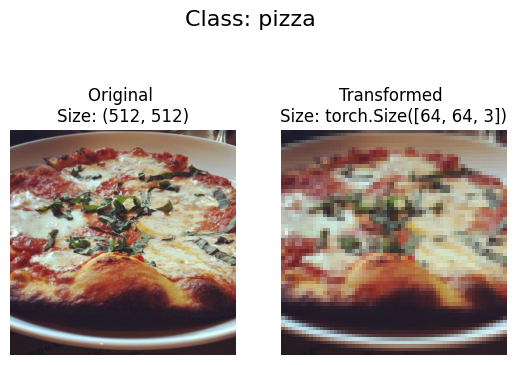

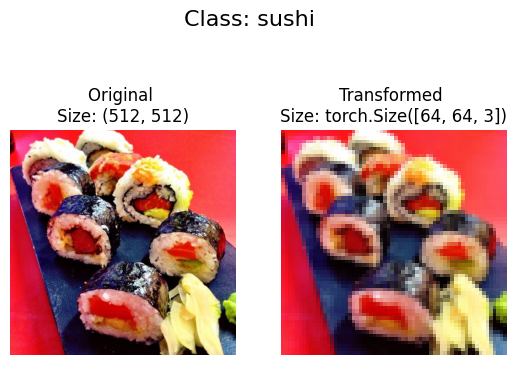

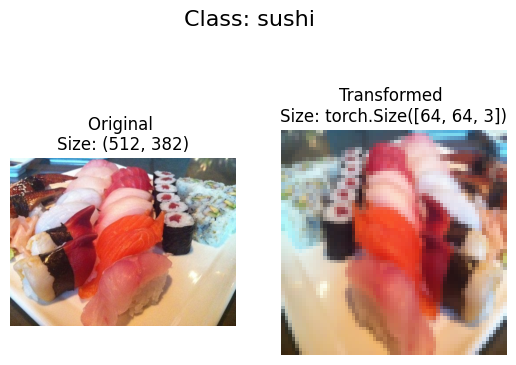

In [ ]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
  """Plots n transformed images."""
  random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(1,2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original \nSize: {f.size}")
      ax[0].axis("off")

      #transform image
      transformed_image = transform(f).permute(1, 2, 0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize = 16)

plot_transformed_images(img_path_list, data_transform, n =3)

# Lodaing image using ImageFolder

In [ ]:
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, transform=data_transform, target_transform=None)
test_data = datasets.ImageFolder(root=test_dir, transform=data_transform, target_transform=None)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [ ]:
#get class names
class_names = train_data.classes
class_dict = train_data.class_to_idx
class_names, class_dict

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

Turn Loaded Images into DataLoaders

In [ ]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data, batch_size=1, shuffle=True, num_workers=1, pin_memory=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=1, shuffle=False, num_workers=1, pin_memory=True)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7b3055964490>,
 <torch.utils.data.dataloader.DataLoader at 0x7b3055c7d950>)

# Loading Image Data with a Custom Dataset

In [ ]:
import os
import pathlib
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

In [ ]:
def find_classes(directory: str):
  """Finds the class folder names in a target directory."""
  #get the class anmes
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
  #raise error if class names not found
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
  #create a dictionary of index labels
  class_to_idx = {cls_name: i
                  for i, cls_name in enumerate(classes)}
  return classes, class_to_idx

In [ ]:
find_classes(train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [ ]:
#write a custom dataset class
from torch.utils.data import Dataset

class ImageFolderCustom(Dataset):
  def __init__(self,
               targ_dir: str,
               transform = None):
    #create class attributes
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    self.transform = transform
    #setup class names
    self.classes, self.class_to_idx = find_classes(targ_dir)

  def load_image(self, index: int):
    image_path = self.paths[index]
    image = Image.open(image_path)
    return image

  def __len__(self):
    return len(self.paths)

  def __getitem__(self, index: int):
    image = self.load_image(index)
    class_name = self.paths[index].parent.name
    class_idx = self.class_to_idx[class_name]
    if self.transform:
      return self.transform(image), class_idx
    else:
      return image, class_idx

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])
test_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

In [ ]:
train_data_custom = ImageFolderCustom(train_dir, transform=train_transform)
test_data_custom = ImageFolderCustom(test_dir, transform=test_transform)
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7b3055d5f510>,
 <__main__.ImageFolderCustom at 0x7b30557f0350>)

In [ ]:
len(train_data_custom), len(test_data_custom)

(225, 75)

## Function to display random images

In [ ]:
def display_random_image(dataset:torch.utils.data.Dataset, classes: list[str] = None, n:int = 10, display_shape: bool = True, seed: int = None):
  # 2. Adjust display if n too high
  if n > 10:
    n = 10
    display_shape = False

  #set random seed
  if seed:
    random.seed(seed)
  #get random samples
  random_samples_idx = random.sample(range(len(dataset)), k=n)
  #setup plot
  plt.figure(figsize=(16,8))
  #loop through samples and display
  for i, targ_idx in enumerate(random_samples_idx):
    img, label = dataset[targ_idx][0], dataset[targ_idx][1]
    img_adjust = img.permute(1, 2, 0)
    #plot samples
    plt.subplot(1, n, i+1)
    plt.imshow(img_adjust)
    plt.axis("off")
    #adjust title
    if classes:
      title = f"class: {classes[label]}"
      if display_shape:
        title = title + f"\nshape: {img.shape}"
    plt.title(title)


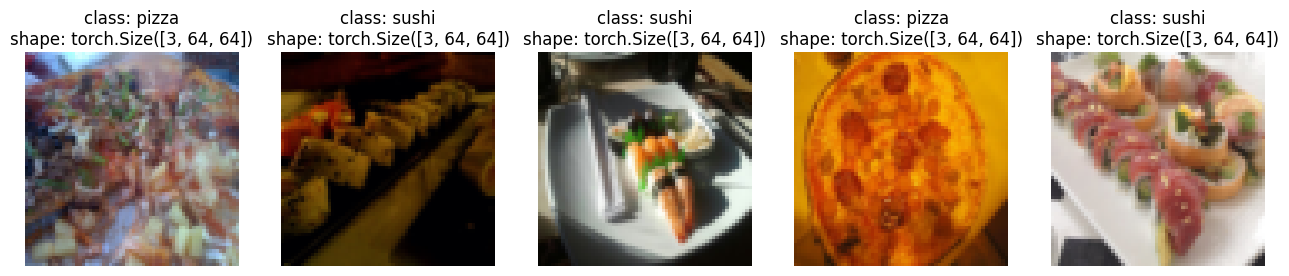

In [ ]:
display_random_image(train_data_custom, classes=train_data_custom.classes, n=5, seed=42)

## Turn iamges into Data Loaders

In [ ]:
from torch.utils.data import DataLoader
train_dataloader_custom = DataLoader(dataset=train_data_custom, batch_size=1, shuffle=True, num_workers=1, pin_memory=True)
test_dataloader_custom = DataLoader(dataset=test_data_custom, batch_size=1, shuffle=False, num_workers=1, pin_memory=True)
train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7b303f3cda10>,
 <torch.utils.data.dataloader.DataLoader at 0x7b303ecf2d10>)

In [ ]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])
#don'ttransform test set
test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

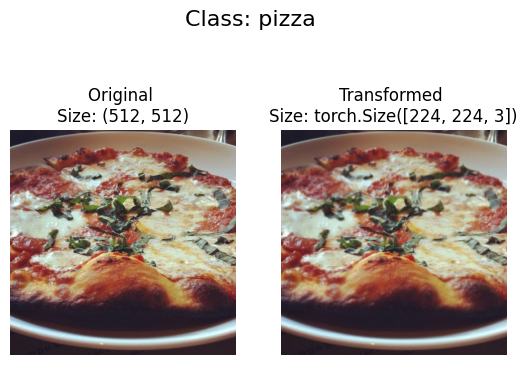

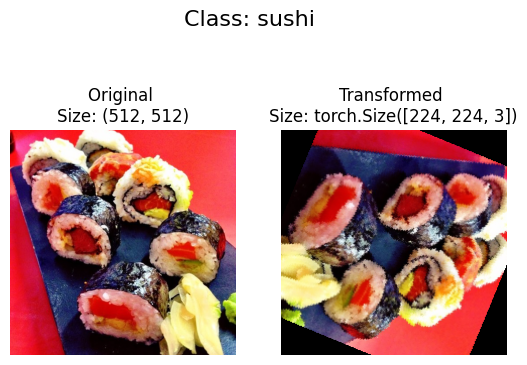

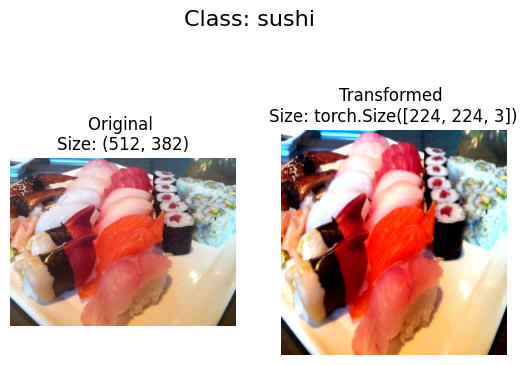

In [ ]:
image_path_list = list(Image_path.glob("*/*/*.jpg"))
#plot random images
plot_transformed_images(image_path_list, train_transform, n=3)

In [ ]:
#create simple transform
simple_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

In [ ]:
#1. load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_transform, target_transform=None)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_transform, target_transform=None)

#2. turn data into data loaders
import os
from torch.utils.data import DataLoader

#Setup batch size and number of workers
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

#create DataLoaders
train_dataloader_simple = DataLoader(dataset=train_data_simple, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_dataloader_simple = DataLoader(dataset=test_data_simple, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
train_dataloader_simple, test_dataloader_simple

Creating DataLoader's with batch size 32 and 12 workers.


(<torch.utils.data.dataloader.DataLoader at 0x7b317f942f50>,
 <torch.utils.data.dataloader.DataLoader at 0x7b3178340d90>)

## Create tinyVGG model

In [ ]:
class TinyVGG(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels = input_shape,
                  out_channels= hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*16*16, out_features=output_shape)
    )
  def forward(self, x: torch.Tensor):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.classifier(x)
    return x

torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, hidden_units=10, output_shape=len(train_data_simple.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [ ]:
#1. get a batch of images and labels from DataLoader
img_batch, label_batch = next(iter(train_dataloader_simple))

#2. get a single image from batch and unsqueeze()
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

#3. perform a forward pass on a single image
model_0.eval()
with torch.inference_mode():
  pred = model_0(img_single.to(device))

#4. print out results
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 64, 64])

Output logits:
tensor([[0.0578, 0.0634, 0.0351]], device='cuda:0')

Output prediction probabilities:
tensor([[0.3352, 0.3371, 0.3277]], device='cuda:0')

Output prediction label:
tensor([1], device='cuda:0')

Actual label:
2


In [ ]:
import torchinfo

from torchinfo import summary
summary(model_0, input_size=(1,3,64,64))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metrics across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [ ]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [ ]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, train_dataloader: torch.utils.data.DataLoader, test_dataloader: torch.utils.data.DataLoader, optimizer: torch.optim.Optimizer, loss_fn: torch.nn.Module = nn.CrossEntropyLoss(), epochs: int = 5):
  #create empty dict of results
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}
  #loop through training and testing steps
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model, dataloader=train_dataloader, loss_fn=loss_fn, optimizer=optimizer)
    test_loss, test_acc = test_step(model=model, dataloader=test_dataloader, loss_fn=loss_fn)

    #print results
    print(
        f"Epoch: {epoch+1} | "
        f"train_loss: {train_loss:.4f} | "
        f"train_acc: {train_acc:.4f} | "
        f"test_loss: {test_loss:.4f} | "
        f"test_acc: {test_acc:.4f}"
    )

    #update results dict
    results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
    results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
    results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
    results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

  return results

## Train and Evaluate

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#set num epochs
NUM_EPOCHS = 5

#create model
model_0 = TinyVGG(input_shape=3, hidden_units=10, output_shape=len(train_data_simple.classes)).to(device)

#setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

#start timer
from timeit import default_timer as timer
start_time = timer()

model_0_results = train(model = model_0, train_dataloader=train_dataloader_simple, test_dataloader=test_dataloader_simple, optimizer=optimizer, loss_fn=loss_fn, epochs=NUM_EPOCHS)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1078 | train_acc: 0.2578 | test_loss: 1.1362 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0847 | train_acc: 0.4258 | test_loss: 1.1621 | test_acc: 0.1979
Epoch: 3 | train_loss: 1.1155 | train_acc: 0.2930 | test_loss: 1.1700 | test_acc: 0.1979
Epoch: 4 | train_loss: 1.0978 | train_acc: 0.4141 | test_loss: 1.1358 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.0991 | train_acc: 0.2930 | test_loss: 1.1425 | test_acc: 0.1979
Total training time: 4.554 seconds


## plot Curves  

In [ ]:
def plot_loss_curves(results):
  loss = results["train_loss"]
  test_loss = results["test_loss"]
  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  epochs = range(len(results["train_loss"]))

  plt.figure(figsize=(15,7))

  plt.subplot(1,2,1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

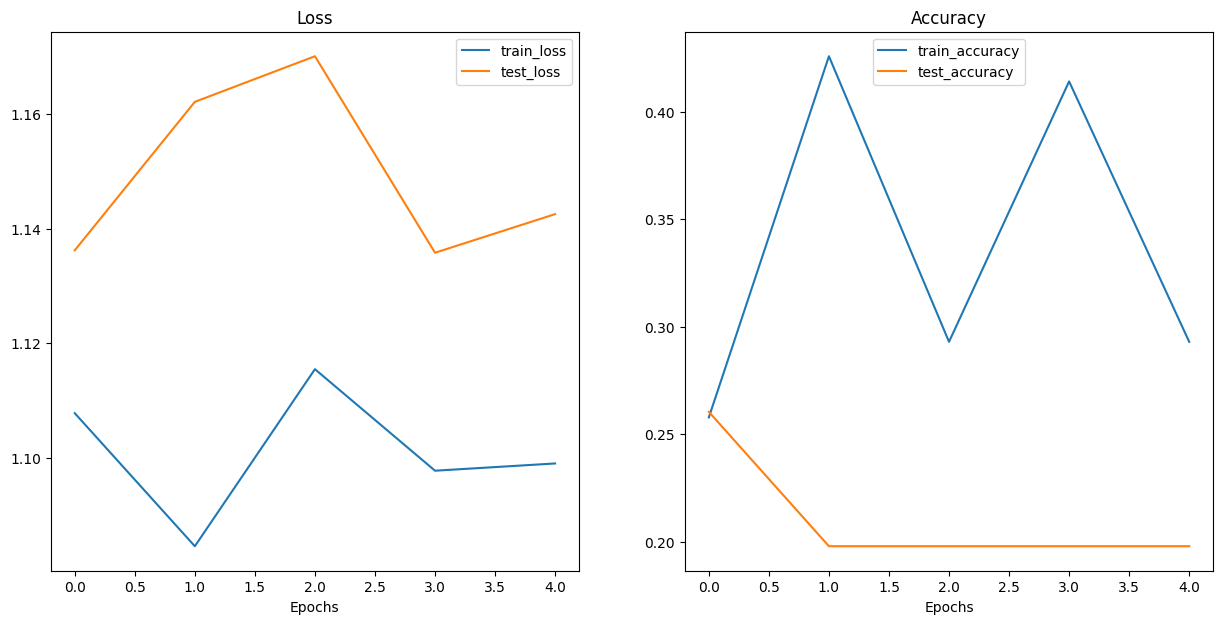

In [ ]:
plot_loss_curves(model_0_results)

## Create transfrom with Data Augmentation

In [ ]:
train_transform_trivial_augment = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])
test_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

## Create train and test DataLoaders

In [ ]:
from ast import Num
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

# Turn image folders into Datasets
train_data_augmented = datasets.ImageFolder(train_dir, transform=train_transform_trivial_augment)
test_data_simple = datasets.ImageFolder(test_dir, transform=test_transform)

train_dataloader_augmented = DataLoader(dataset=train_data_augmented, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_dataloader_simple = DataLoader(dataset=test_data_simple, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
train_dataloader_augmented, test_dataloader_simple

Creating DataLoader's with batch size 32 and 12 workers.


(<torch.utils.data.dataloader.DataLoader at 0x7b317f7d26d0>,
 <torch.utils.data.dataloader.DataLoader at 0x7b317f22db50>)

#Try model 1

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#set num epochs
NUM_EPOCHS = 5

#create model
model_1 = TinyVGG(input_shape=3, hidden_units=10, output_shape=len(train_data_augmented.classes)).to(device)

#setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

#start timer
from timeit import default_timer as timer
start_time = timer()

model_1_results = train(model = model_1, train_dataloader=train_dataloader_augmented, test_dataloader=test_dataloader_simple, optimizer=optimizer, loss_fn=loss_fn, epochs=NUM_EPOCHS)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1078 | train_acc: 0.2578 | test_loss: 1.1375 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0829 | train_acc: 0.4258 | test_loss: 1.1671 | test_acc: 0.1979
Epoch: 3 | train_loss: 1.1212 | train_acc: 0.2930 | test_loss: 1.1731 | test_acc: 0.1979
Epoch: 4 | train_loss: 1.0959 | train_acc: 0.4141 | test_loss: 1.1404 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.0939 | train_acc: 0.2930 | test_loss: 1.1438 | test_acc: 0.1979
Total training time: 4.464 seconds


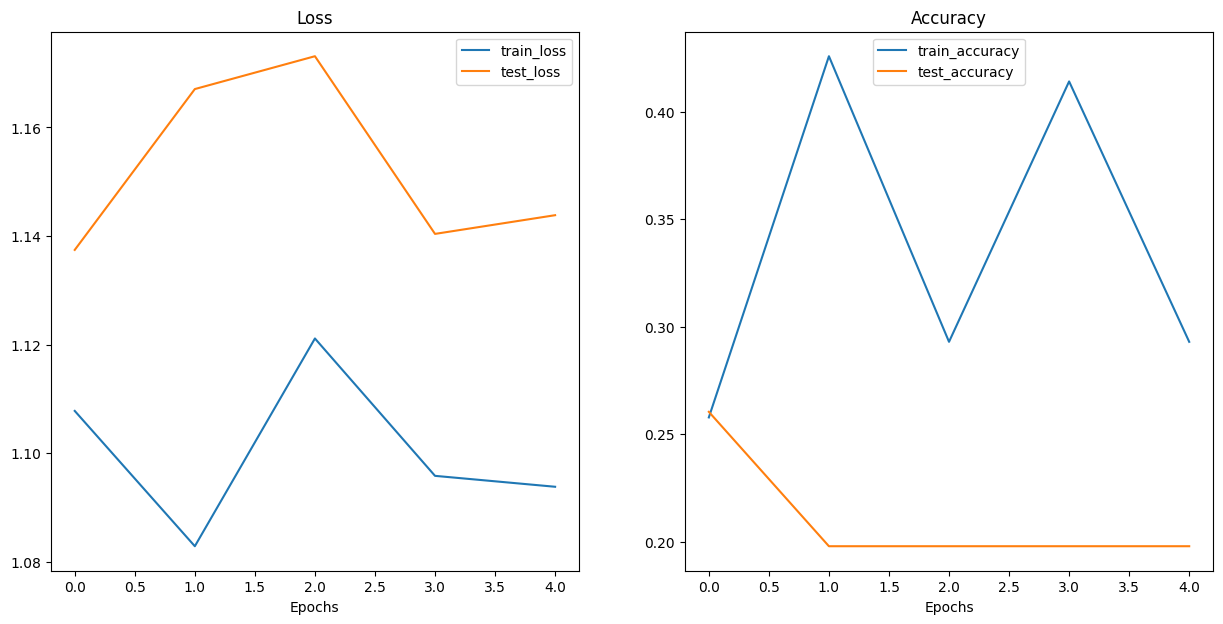

In [ ]:
plot_loss_curves(model_1_results)

## Compare Models

In [ ]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)

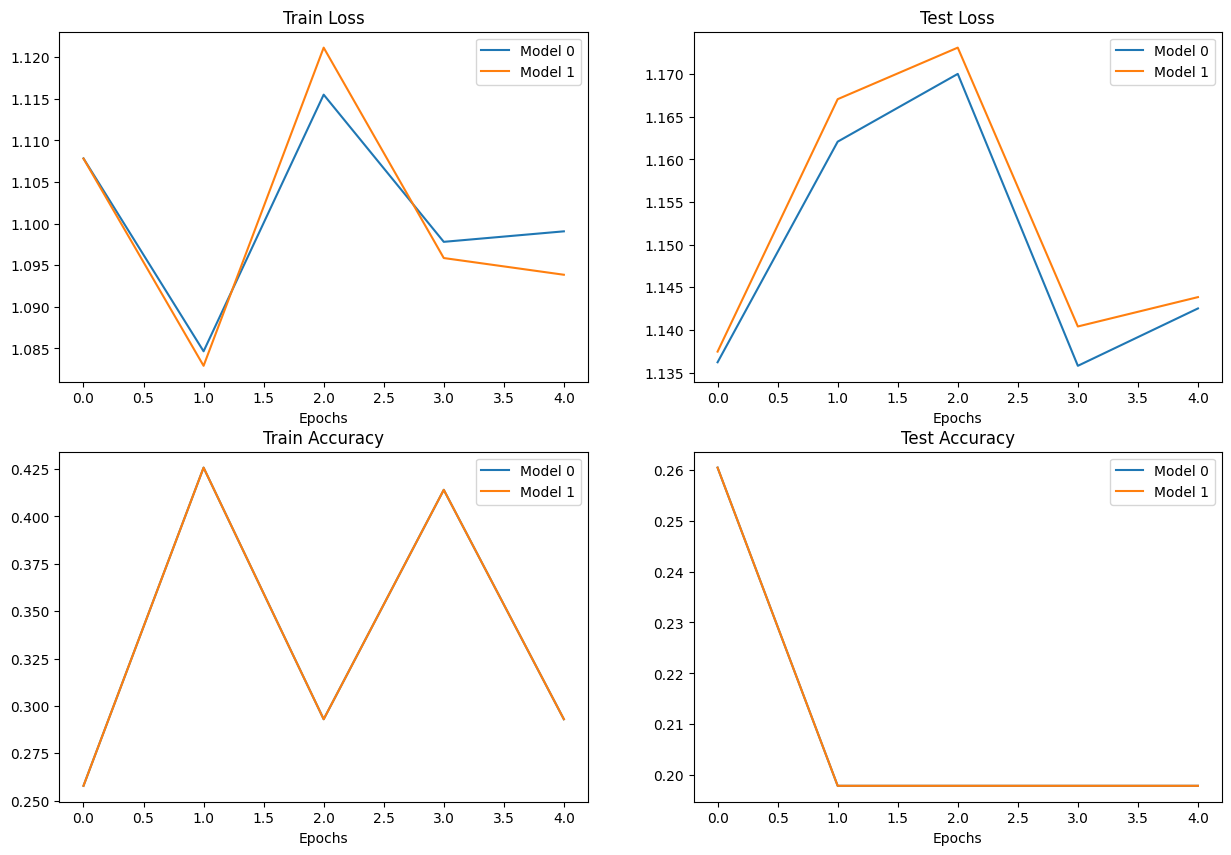

In [ ]:
# Setup a plot
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend();

## Make prediction on custom image

In [ ]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

In [ ]:
import torchvision
# Read in custom image
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)
custom_image = custom_image / 255.

# Print out image data
print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image tensor:
tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..

In [ ]:
# create transform pipeline to resize image
custom_image_transform = transforms.Compose([
    transforms.Resize((64,64)),
])

custom_image_transformed = custom_image_transform(custom_image)

print(f"Custom image shape: {custom_image_transformed.shape}")

Custom image shape: torch.Size([3, 64, 64])


In [ ]:
model_1.eval()
with torch.inference_mode():
  custom_image_pred = model_1(custom_image_transformed.unsqueeze(dim=0).to(device))
custom_image_pred

tensor([[ 0.0436,  0.0623, -0.1519]], device='cuda:0')

In [ ]:
# Print out prediction logits
print(f"Prediction logits: {custom_image_pred}")

# Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
print(f"Prediction probabilities: {custom_image_pred_probs}")

# Convert prediction probabilities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
print(f"Prediction label: {custom_image_pred_label}")

#print out label
custom_image_pred_class = class_names[custom_image_pred_label.cpu()]
print(f"Prediction class: {custom_image_pred_class}")

Prediction logits: tensor([[ 0.0436,  0.0623, -0.1519]], device='cuda:0')
Prediction probabilities: tensor([[0.3520, 0.3586, 0.2895]], device='cuda:0')
Prediction label: tensor([1], device='cuda:0')
Prediction class: steak


In [ ]:
def pred_and_plot_image(model: torch.nn.Module, image_path: str, class_names: list[str] = None, transform: torchvision.transforms = None, device: torch.device = device):
  """Makes a prediction on a target image and plots the image with the prediction"""
  # 1. Load in image
  target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

  # 2. Divide the image pixel value by 255
  target_image = target_image / 255.

  # 3. Transform the image to fit the model requirements
  if transform is not None:
    target_image = transform(target_image)

  # 4. make sure model is on target device
  model.to(device)

  # 5 turn on model evalutaion mode
  model.eval()
  with torch.inference_mode():
    target_image = target_image.unsqueeze(dim=0).to(device)
    target_image_pred = model(target_image)
    # 6. convert logits -> probabilities
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
    # 7. convert probabilities -> labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
    # 7. plot image alongside prediciton
    plt.imshow(target_image.squeeze().permute(1,2,0))
    if class_names:
      title = f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
      title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False)

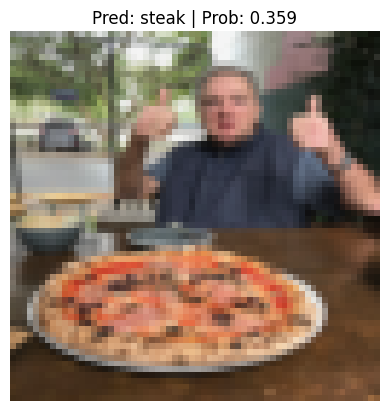

In [ ]:
pred_and_plot_image(model=model_1,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device='cpu')